In [1]:
from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np
#import keras
#from keras import backend as K

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

tf.random.set_seed(101)

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset_dir = '../../Documents/skin-cancer-mnist-ham10000/'
base_dir = 'base_dir'
train_dir = os.path.join(base_dir, 'train_dir')
val_dir = os.path.join(base_dir, 'val_dir')

df_data = pd.read_csv(dataset_dir + '/HAM10000_metadata.csv')

# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]
df.reset_index(inplace=True)


# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(x):
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

# now we filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

9077
938


In [3]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


datagen = ImageDataGenerator(
    preprocessing_function= \
    tf.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 40093 images belonging to 7 classes.
Found 1860 images belonging to 7 classes.
Found 1860 images belonging to 7 classes.


In [4]:
# create a copy of a mobilenet model
mobile = tf.keras.applications.mobilenet.MobileNet()

mobile.summary()
print(type(mobile.layers))
# How many layers does MobileNet have?
print(len(mobile.layers))

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [5]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

In [6]:
# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

# Get the labels that are associated with each index
print(valid_batches.class_indices)

# Add weights to try to make the model more sensitive to melanoma

class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 2.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [7]:
filepath = "mobilenet_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)


Epoch 1/30
907/908 [============================>.] - ETA: 0s - loss: 1.5768 - categorical_accuracy: 0.5437 - top_2_accuracy: 0.7383 - top_3_accuracy: 0.8527
Epoch 00001: val_top_3_accuracy improved from -inf to 0.86064, saving model to mobilenet_model.h5
908/908 [==============================] - 131s 144ms/step - loss: 1.5765 - categorical_accuracy: 0.5437 - top_2_accuracy: 0.7382 - top_3_accuracy: 0.8528 - val_loss: 2.0612 - val_categorical_accuracy: 0.5287 - val_top_2_accuracy: 0.7043 - val_top_3_accuracy: 0.8606
Epoch 2/30
907/908 [============================>.] - ETA: 0s - loss: 1.1318 - categorical_accuracy: 0.6322 - top_2_accuracy: 0.8272 - top_3_accuracy: 0.9228
Epoch 00002: val_top_3_accuracy did not improve from 0.86064
908/908 [==============================] - 118s 130ms/step - loss: 1.1322 - categorical_accuracy: 0.6320 - top_2_accuracy: 0.8271 - top_3_accuracy: 0.9227 - val_loss: 5.1215 - val_categorical_accuracy: 0.1096 - val_top_2_accuracy: 0.6362 - val_top_3_accuracy

Epoch 17/30
907/908 [============================>.] - ETA: 0s - loss: 0.3765 - categorical_accuracy: 0.8814 - top_2_accuracy: 0.9721 - top_3_accuracy: 0.9935
Epoch 00017: val_top_3_accuracy did not improve from 0.97340
908/908 [==============================] - 117s 129ms/step - loss: 0.3765 - categorical_accuracy: 0.8813 - top_2_accuracy: 0.9720 - top_3_accuracy: 0.9935 - val_loss: 0.7717 - val_categorical_accuracy: 0.7457 - val_top_2_accuracy: 0.9149 - val_top_3_accuracy: 0.9660
Epoch 18/30
907/908 [============================>.] - ETA: 0s - loss: 0.3910 - categorical_accuracy: 0.8748 - top_2_accuracy: 0.9727 - top_3_accuracy: 0.9946
Epoch 00018: val_top_3_accuracy did not improve from 0.97340

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
908/908 [==============================] - 120s 132ms/step - loss: 0.3907 - categorical_accuracy: 0.8749 - top_2_accuracy: 0.9728 - top_3_accuracy: 0.9946 - val_loss: 0.7801 - val_categorical_accuracy: 0.7489 - 

In [8]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [9]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 1.1755069766170418
val_cat_acc: 0.6183369
val_top_2_acc: 0.8379531
val_top_3_acc: 0.93710023


In [11]:
# Here the best epoch will be used.

model.load_weights('mobilenet_model.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 1.1277745575623541
val_cat_acc: 0.6257996
val_top_2_acc: 0.8326226
val_top_3_acc: 0.9434968


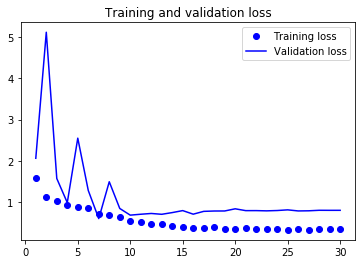

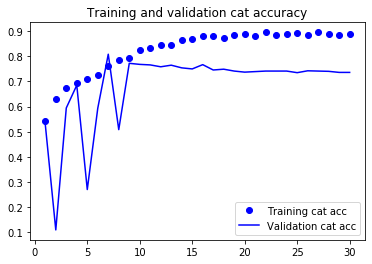

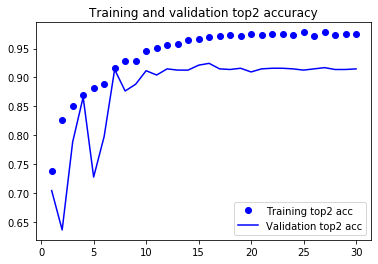

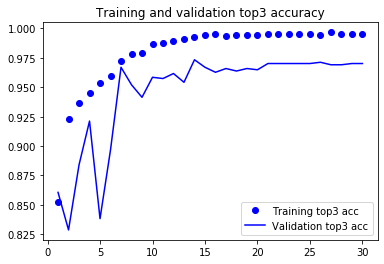

In [12]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

In [32]:
IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained model MobileNet V2
mobilev2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               weights='imagenet')
mobilev2.summary()
print(type(mobilev2.layers))
# How many layers does MobileNet have?
print(len(mobilev2.layers))

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.
x = mobilev2.layers[-2].output
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=mobilev2.input, outputs=predictions)

# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-2]:
    layer.trainable = False

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [33]:
base_learning_rate = 0.0001

model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

filepath = "mobilenetv2_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/30
 15/908 [..............................] - ETA: 2:29 - loss: 3.3564 - categorical_accuracy: 0.2933 - top_2_accuracy: 0.4600 - top_3_accuracy: 0.5667

KeyboardInterrupt: 

In [34]:
from MobileNet_V3 import build_mobilenet_v3
model = build_mobilenet_v3(input_size=224, num_classes=7, model_type='large', pooling_type='avg', include_top=True)

print(model.summary())
print(len(model.layers))

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_103 (Conv2D)             (None, 112, 112, 16) 432         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_142 (BatchN (None, 112, 112, 16) 64          conv2d_103[0][0]                 
__________________________________________________________________________________________________
activation_59 (Activation)      (None, 112, 112, 16) 0           batch_normalization_142[0][0]    
____________________________________________________________________________________________

In [36]:
base_learning_rate = 0.0001

model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

print('1')

filepath = "mobilenetv2_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

print('2')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
print('3')
callbacks_list = [checkpoint, reduce_lr]

print('4')

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=10,
                   callbacks=callbacks_list)

1
2
3
4


KeyboardInterrupt: 